# Redes Neurais FC para classificação com dados tabulares e seus *pitfalls*

![d1](https://user-images.githubusercontent.com/32513366/98948879-c7950c00-24d5-11eb-8198-102f994c2d1e.png)

Este notebook terá como intuito apresentar a utilizar das redes totalmente conectadas para realizar uma classificação binária em dados tabulares.

# Motivação
Esta base de dados foi utilizada anteriormente em uma das minhas disciplina de inteligência artificial na Universidade. Usando como artigo de referência encontrado na pasta `documentos`: [**Using Resistin, glucose, age and BMI to predict the presence of breast cancer**](https://bmccancer.biomedcentral.com/articles/10.1186/s12885-017-3877-1#:~:text=Results,was%20%5B0.87%2C%200.91%5D.). Esta base de dados conta com nove variáveis de entrada, uma variável de saída binária (presença/ausência do tumor) e 116 amostras. 

A baixa amostragem pode ser um empecilho para redes neurais, conhecidas por serem "*Data Hungry*". Vamos explorar neste notebook um caminho diferente do que tomei em meu trabalho de 2018 (encontrado também na pasta `documentos`) para buscar resultados diferentes com este modelo. Será que uma FC será capaz de trazer bons resultados com um conjunto tão pequeno?


# Bibliotecas

In [2]:
# Basico e plots
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import matplotlib.pyplot as plt

# Processamento
import missingno as msno
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# BUG - SKOPT
# Workaround for skopt with sklearn==0.23.1
#from numpy.ma import MaskedArray
#import sklearn.utils.fixes
#sklearn.utils.fixes.MaskedArray = MaskedArray

# Development
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import models, layers, optimizers, Input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Comandos para o notebook
%matplotlib inline
warnings.filterwarnings('ignore')

# Conhecendo algumas informações da base de dados

In [3]:
# Importando o dataset
df = pd.read_csv('dataset.csv')

In [4]:
# Visualizando rapidamente a base de dados
df

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,2
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,2
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,2


Podemos verificar que o problema avaliado na introdução é de fato real: **baixa quantidade amostral**. Modelos complexos como redes neurais sofrem bastante para situações como esta. O mais recomendado seria utilizar modelos mais clássicos como Máquinas de Vetores de Suporte, Florestas Aleatórias ou K-NN. 

Ao se trabalhar com bases de dados pequenas diversos artifícios podem ser usados para evitar sobreajuste de modelo:
- Criar amostras sintéticas
- Diminuir a complexidade do conjunto de *features*
- Utilizar modelos mais clássicos como Máquinas de Vetores de Suporte, Florestas Aleatórias ou K-NN que são mais simples e menos "famintos por dados" como as redes neurais.

Como o intuito deste material é fazer uma rede neural para classificação apenas, não irei adentrar tanto no primeiro e terceiro ponto para não perder o foco.

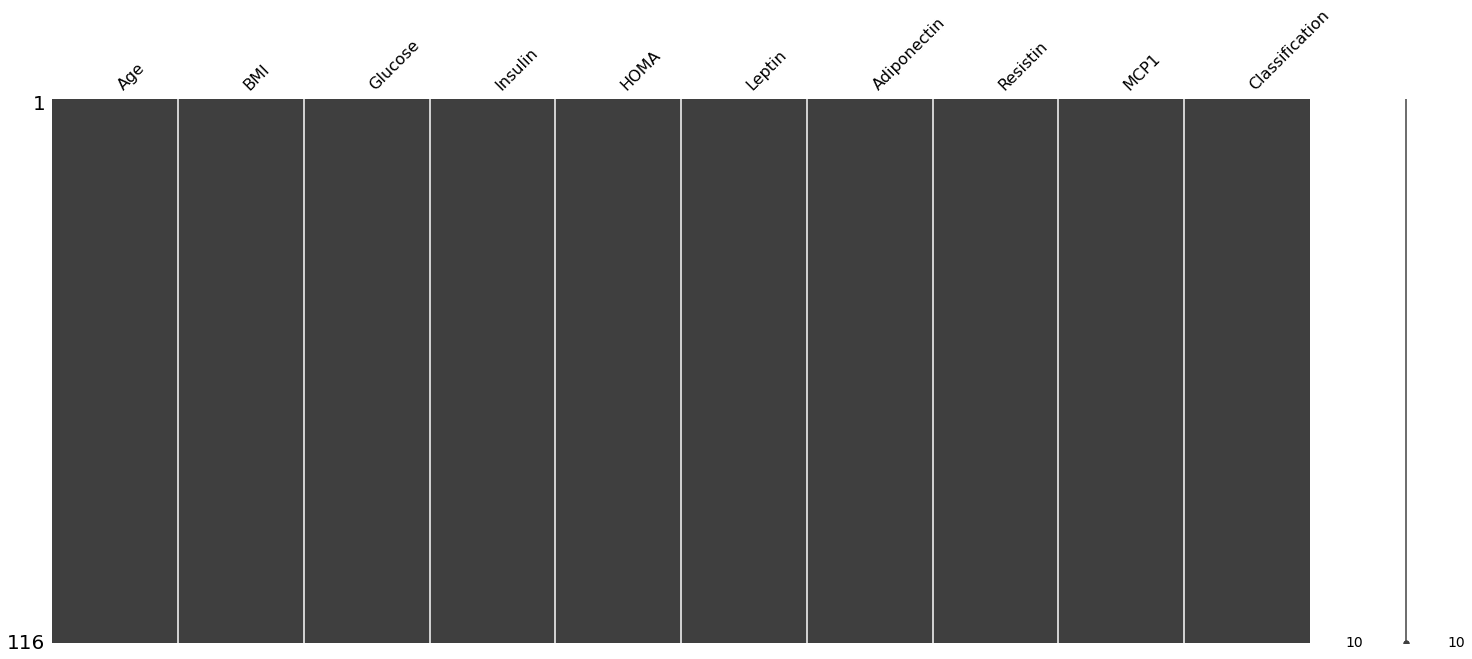

In [5]:
# Verificando a existência de valores faltantes
msno.matrix(df);

Base de dados está completa, logo não teremos que se preocupar com entender os valores faltantes e sua imputação!

In [6]:
# Definindo conjunto de features e variável objetivo
features = df.columns[:-1]
target = df.columns[-1]

In [7]:
# Verificando a distribuição para cada classe
round(100*df[target].value_counts()/len(df), 2)

2    55.17
1    44.83
Name: Classification, dtype: float64

Podemos verificar que as classes estão bem balanceadas!

# Análise Exploratória dos dados
Aqui vamos explorar rapidamente a base de dados para tirar insights para o futuro.

## Construção de mapa de calor para o conjunto de entrada (*features*)

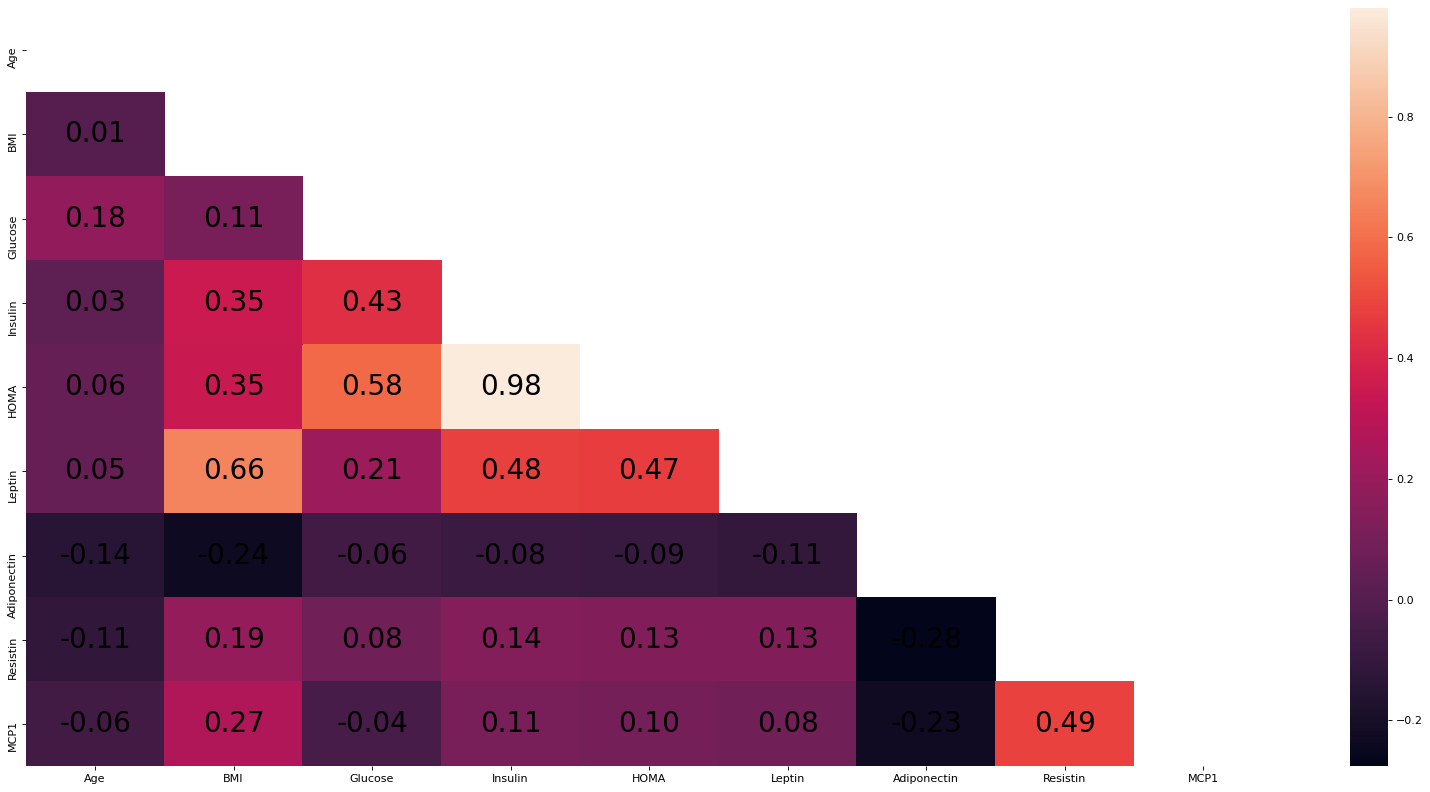

In [8]:
# Calculando a matriz de correlação
corr_matriz = df[features].corr('spearman')

# Plot
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(corr_matriz, annot = True, mask=np.triu(corr_matriz), annot_kws={'fontsize':25, 'color':'black'}, fmt='.2f')
plt.tight_layout()

Podemos verificar uma correlação imensa entre a variável `HOMA` e `Insulin`. Diversos modelos sofrem com variáveis correlacionadas (podem causar uma certa confusão nos modelos e aumentam a complexidade do conjunto de *features* de forma desnecessária). Além delas `Leptin` e `BMI` assim como `Glucose` e `HOMA` demonstram uma correlação intermediária.

Para ficar claro, os níveis de correlação que considero são:
- Acima de 0.80: Forte
- Abaixo de 0.50: Fraca
- Entre esses valores: Intermediária

Mantenha em mente esses conjuntos de variáveis citados, principalmente `HOMA`, pois pelo menos uma será eliminada da análise.

## Distribuição das variáveis particionada pela categoria de classificação

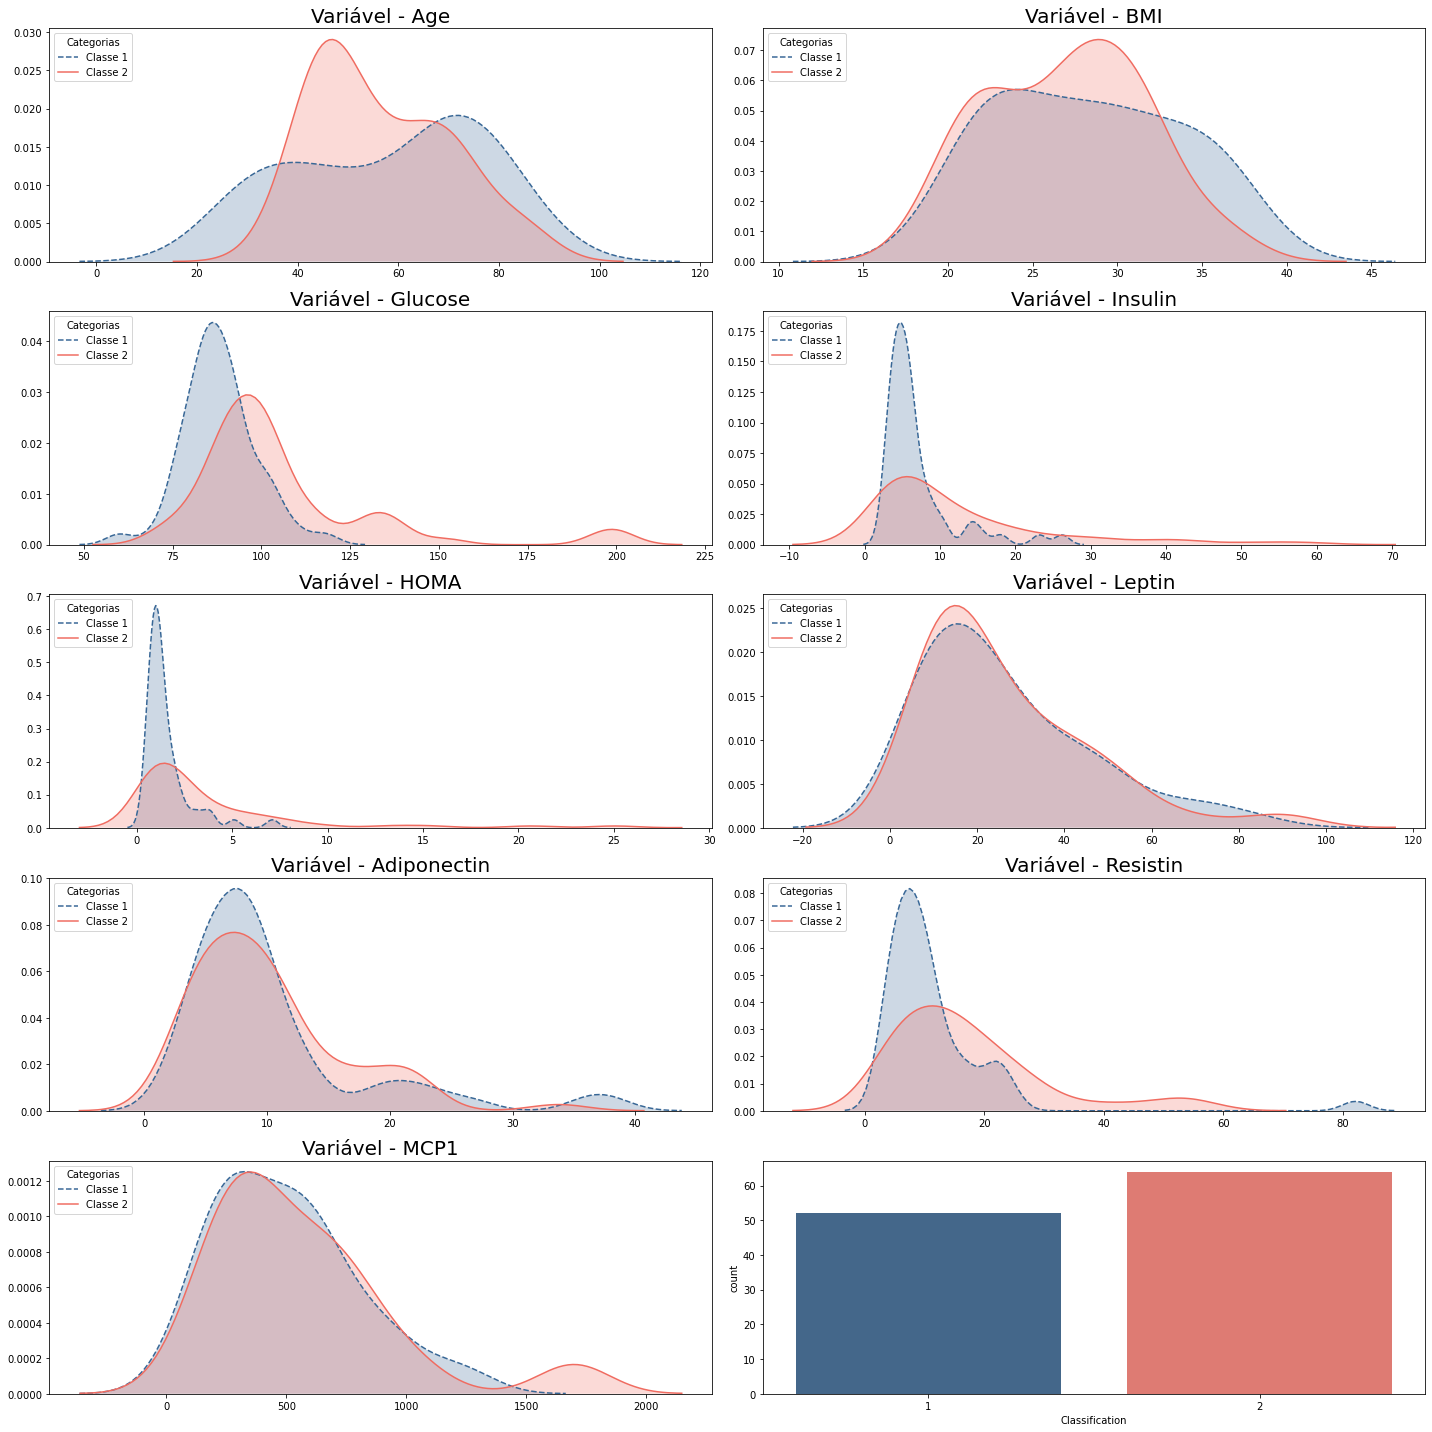

In [9]:
# Definindo a figura
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(df.loc[df[target]==1, f], shade=True, color='#386796', ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(df.loc[df[target]==2, f], shade=True, color='#F06C61', ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1
        
# Variavel objetivo
sns.countplot(x=target, data=df, palette={1:'#386796',2:'#F06C61'})

# Melhorar a visualizacao final
plt.tight_layout()

Buscava neste gráfico encontrar variáveis que conseguissem separar bem suas amostras de acordo ao conjunto de categorias na saída. A variável `Glucose` é a que mais chega próxima deste objetivo enquanto a variável `Leptin` é a que mais fracassa nesta meta: a distribuição tanto para a categoria 1 quanto para a categoria 2 são praticamente idênticas. Vamos explorar isso mais a frente na próxima seção.

Todavia, um ponto interessante visualizado neste gráfico é: as variáveis `Glucose`,`Resistin`,`HOMA` e `Insulin` demonstraram picos para uma faixa de valores em relação a categoria 1. Esta alta densidade pode ser uma característica interessante que o modelo pode extrair para definir o tipo de categoria para classificação.

## Diagrama de caixas para as variáveis de entrada
Vamos visualizar um pouco mais sobre a distribuição dessas variáveis, verificar se existem muitos valores aberrantes também.

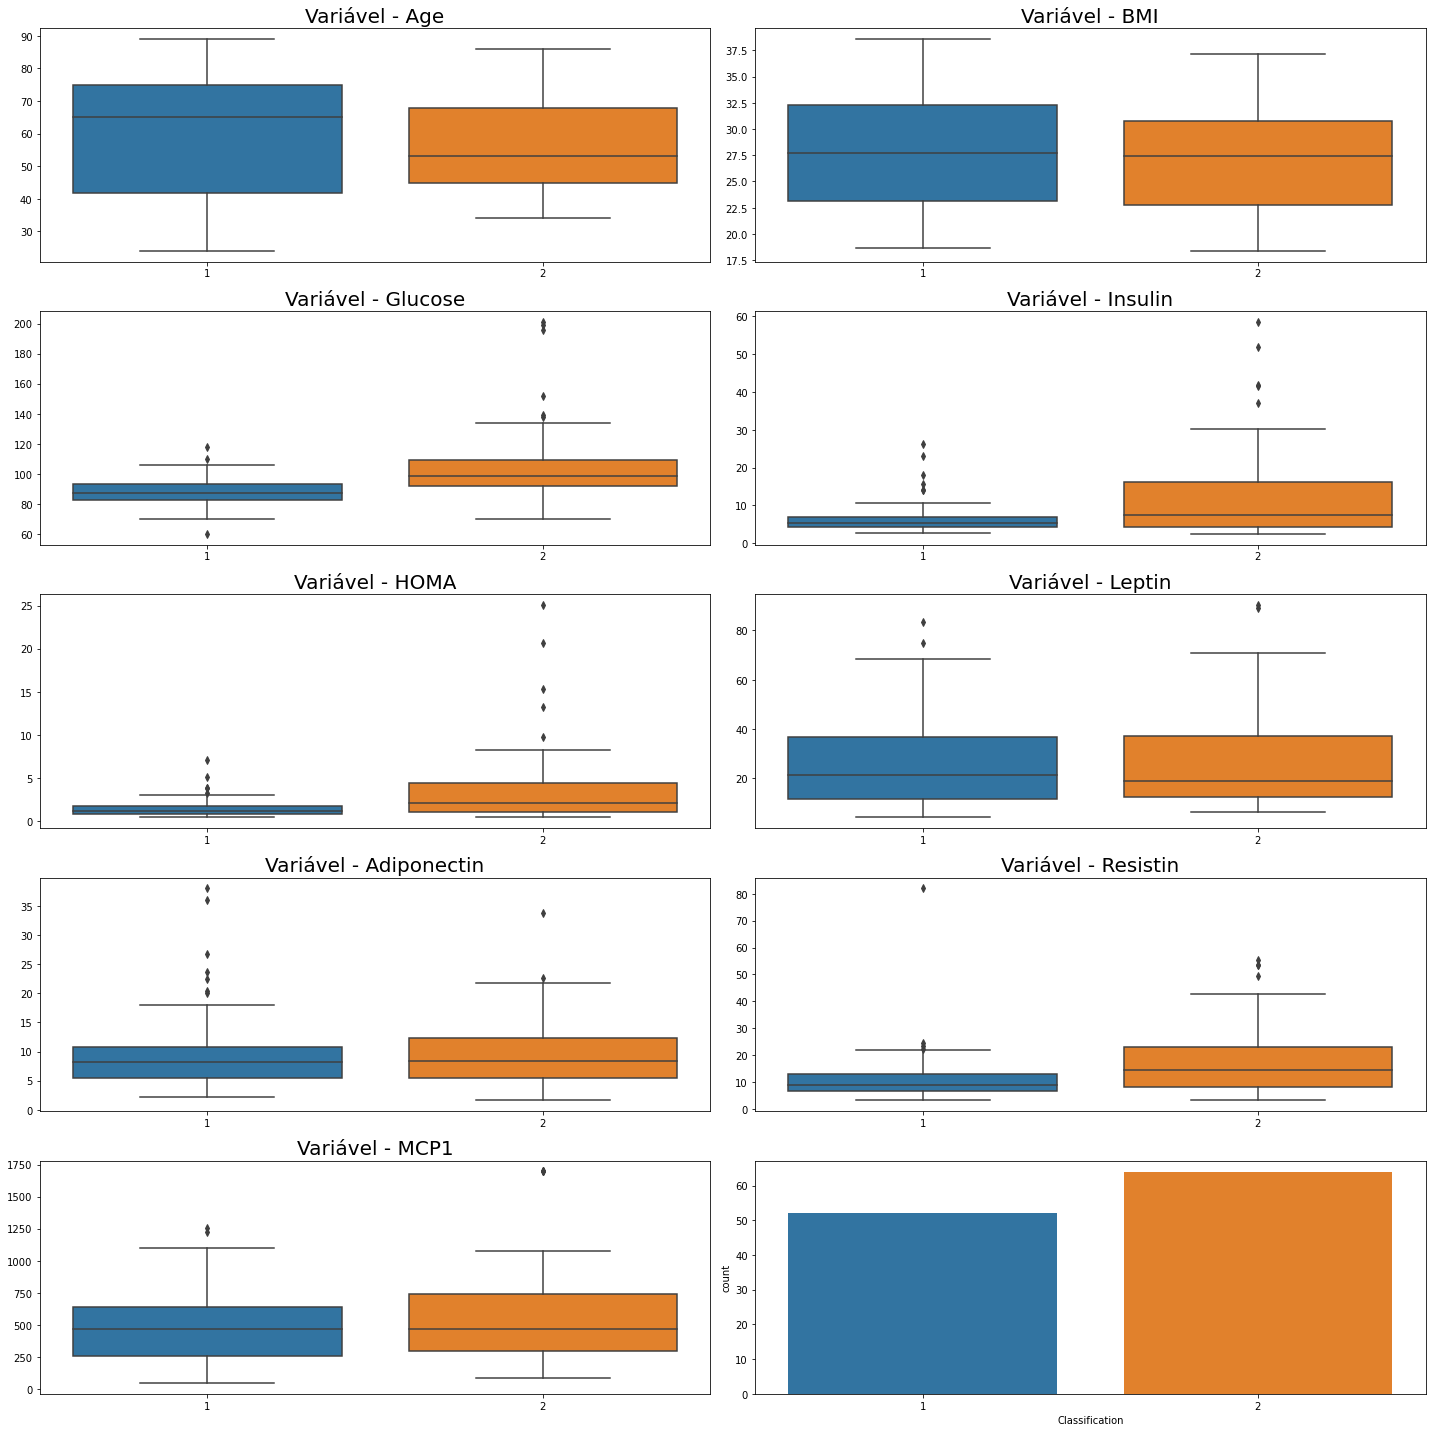

In [10]:
# Definindo a figura
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.boxplot(x=target, y=f, data=df, ax=axes[r][c])
    # Configuracoes do plot
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    axes[r][c].set_ylabel('')
    axes[r][c].set_xlabel('')
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1
        
# Variavel objetivo
sns.countplot(x=target, data=df)

# Melhorar a visualizacao final
plt.tight_layout()

No geral, verificamos uma presença de valores aberrantes em todas as variáveis com exceção `Age` e `BMI`. Além disso, verificamos de forma mais clara um dos resultados verificados na distribuição do conjunto de entradas para `Glucose`,`Resistin`,`HOMA` e `Insulin`: **seus diagramas de caixas para a categoria 1 são achatados em uma faixa de valor**. Esses padrões serão considerados para a seleção do método de processamento dos valores na seção seguinte.

# Pré-processamento
Aqui será feito a divisão treino/teste assim como a transformação do conjunto de entradas para remover os problemas de dimensionalidades das variáveis (enquanto uma varia de 0 a 30 outra varia de 0 a 1700).

## Divisão Treino/Teste

In [11]:
# Divisão Treino/Teste com proporcao 85/15
x_train, x_test, y_train, y_test = tts(df[features], df[target], test_size=0.15, random_state=1206, stratify=df[target])

In [12]:
# Verificando a quantidade de amostras em cada conjunto
print('Tamanho conjunto de treino: ',len(x_train))
print('Tamanho conjunto de teste: ',len(x_test))

Tamanho conjunto de treino:  98
Tamanho conjunto de teste:  18


In [13]:
# Verificando a proporcao da variável objetivo - conjunto treino
round(y_train.value_counts()/len(y_train), 2)

2    0.55
1    0.45
Name: Classification, dtype: float64

In [14]:
# Verificando a proporcao da variável objetivo - conjunto teste
round(y_test.value_counts()/len(y_test), 2)

2    0.56
1    0.44
Name: Classification, dtype: float64

É importante definir a opção `stratify` ao realizar esta divisão para evitar a predominância de uma determinada classe no conjunto de treino ou teste. Assim, tanto o conjunto de treino como o de teste possuem a mesma proporção.

**NOTA**: Agora irei reavaliar todos os gráficos que gerei na seção anterior apenas para o conjunto de treinamento. Note que não tomei nenhuma decisão naquele momento por precaução para evitar o fenômeno chamado *Data Leakage*. Todavia, acredito que se eu quisesse naquele instante remover variáveis altamente correlacionadas eu poderia sem nenhum problema (não o fiz por escolha). De certa forma, as decisões de pré-processamento, seleção de variáveis serão feitas apenas com o conjunto de treino.

## Mapa de calor do conjunto de treino

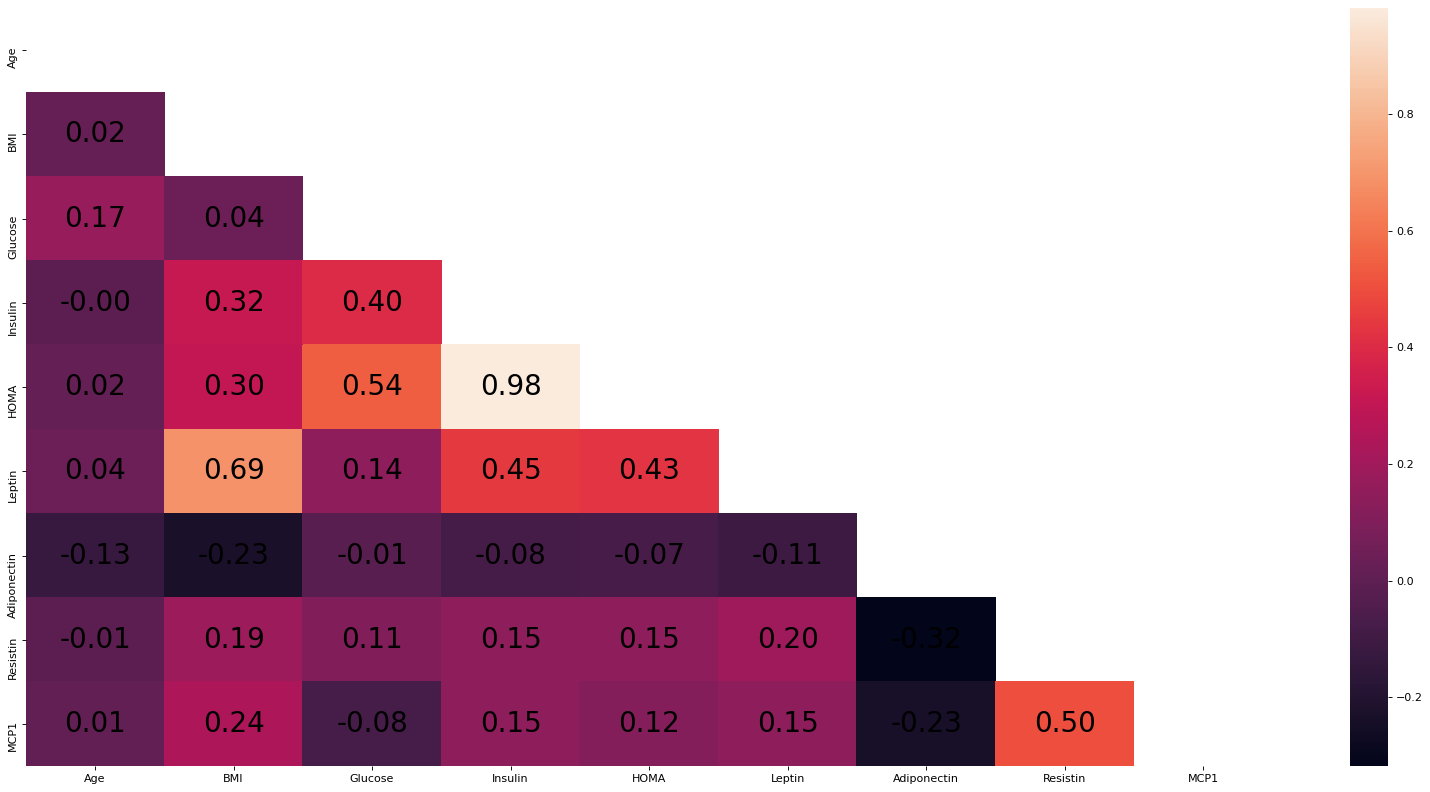

In [15]:
# Calculando a matriz de correlação
corr_matriz = x_train.corr('spearman')

# Plot
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(corr_matriz, annot = True, mask=np.triu(corr_matriz), annot_kws={'fontsize':25, 'color':'black'}, fmt='.2f')
plt.tight_layout()

Vemos que a correlação `HOMA` e `Insulin` persistem. Note que as outras duas correlações intermediárias que eu havia citado alteraram um pouco.

## Distribuição do conjunto de treino particionado pela categoria de classificação

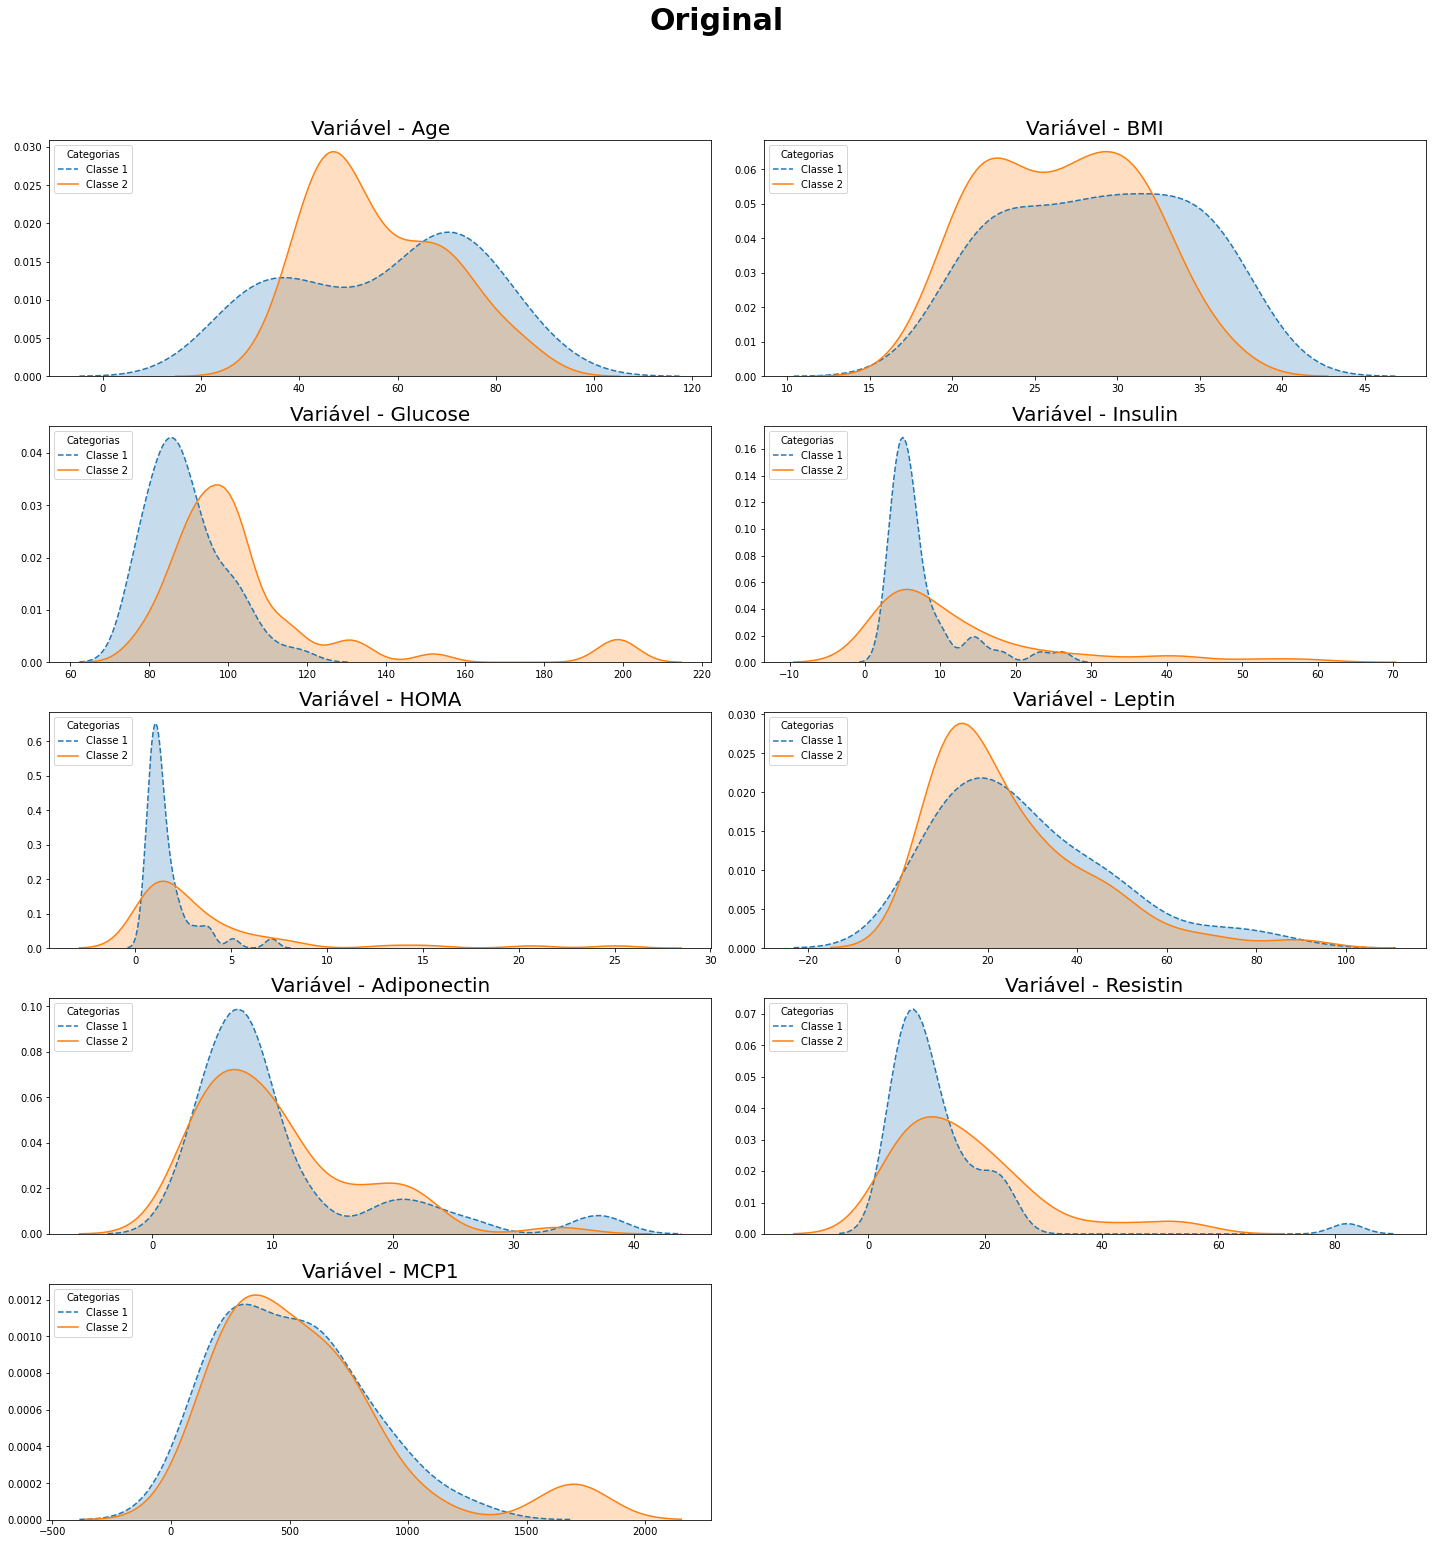

In [16]:
# Definindo a figura
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Original', fontsize=30, fontweight='bold', y=1.07)
# Remover ultimo eixo
fig.delaxes(axes[4][1])

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(x_train.loc[y_train==1, f], shade=True, ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(x_train.loc[y_train==2, f], shade=True, ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

# Salvar imagem para fazer GIF
fig.savefig('figuras/original.png', bbox_inches='tight');

Podemos verificar que `Glucose`,`Resistin`,`HOMA` e `Insulin` demonstram um padrão equivalente ao explorado anteriormente. Isto vale para as outras variáveis. Sendo assim, assumindo uma causa e efeito para evitar repetir o diagrama de caixas, acredito que o diagrama de caixas irá possuir o mesmo padrão.

## Formas de transformação das variáveis
Serão avaliadas 3 formas de transformação de variáveis para encontrar a melhor que se encaixa para este conjunto. Normalmente, o padrão é aplicar uma **padronização (diminuir pela média e dividir pelo desvio padrão)**, porém aqui farei de forma diferente: irei buscar o método capaz de apresentar uma maior separação entre categorias no gráfico de distribuição. A ideia é permitir uma maior facilidade para o modelo conseguir discernir a categoria.

Os três métodos que serão avaliados são:
- Padronização
- Normalização
- Normalização robusta
- Transformação exponencial 

Para cada método irei apresentar a fórmula e discorrer rapidamente sobre o mesmo.

### Método 1 - Padronização

![m1](https://user-images.githubusercontent.com/32513366/98945203-f2c92c80-24d0-11eb-8fed-d95e61892361.png)

Metodologia padrão para dados tabulares.

In [17]:
# Definir transformador
transformador = StandardScaler()
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

### Método 2 - Normalização

![m2](https://user-images.githubusercontent.com/32513366/98945205-f361c300-24d0-11eb-9a1c-71b30572d28e.png)

Muito utilizado para tratamento de imagens. Basicamente é utilizado os valores máximo/mínimo da variável para coloca-las em uma mesma faixa. Note que este tipo de transformação não é robusta quando temos valores aberrantes.

In [18]:
# Definir transformador
transformador = MinMaxScaler()
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

### Método 3 - Normalização robusta

![m3](https://user-images.githubusercontent.com/32513366/98945197-f2309600-24d0-11eb-8f0b-e654dcff530d.png)

Funciona como a normalização apresentada anteriormente, porém busca reverter o ponto fraco de valores aberrantes usando os quartis:
- Q1 (define o valor para o qual 25% dos valores estão abaixo dele)
- Q3 (define o valor para o qual 75% dos valores estão abaixo dele)

In [19]:
# Definir transformador
transformador = RobustScaler()
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

### Método 4 - Transformação Exponencial

![m4](https://user-images.githubusercontent.com/32513366/98945201-f2c92c80-24d0-11eb-8101-1a0371f812dd.png)

Esta transformação exponencial Yeo-Johnson se trata de uma extensão da transformação Box-Cox para aceitar valores negativos.

In [20]:
# Definir transformador
transformador = PowerTransformer(method='yeo-johnson')
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

# Avaliando os resultados para as transformações através de um GIF
**OBS**: Eu gerei as imagens e então exclui os blocos de códigos para tornar o notebook mais legível.

![transformacao](https://user-images.githubusercontent.com/32513366/96348966-df1dd800-1082-11eb-9d24-89bef73d5537.gif)

Através de uma rápida visualização gráfica conseguimos perceber que no geral apenas a transformação exponencial mudou a distribuição em comparação com a curva original, os outros métodos demonstraram apenas mudança na escala. Neste momento temos uma decisão:
- Utilizar a **Transformação exponencial**, pois conseguiu em algumas variáveis como `Glucose`, `Resistin` e `Insulin` fazer uma boa separação.
- Utilizar a **Padronização** ou qualquer outra transforamação, pois alterou apenas a escala das variáveis mantendo o formato da distribuição idêntico.

Irei optar pela **Padronização** mantendo o padrão de 99% dos dados da Kaggle! Mas caso você queira testar outro tipo, fique a vontade. O motivo ocorre dado ao fato de eu não encontrar uma separação desejada.

Vamos gerar amostras sintéticas. Como sabemos, as Deep Learning são bem famintas diferente de métodos clássicos como LR, SVM e RF.

## Aplicar transformação
* SMOTE usa KNN e este tipo de modelo é sensível a diferença de escala.

In [21]:
# Definir transformador
transformador = StandardScaler()
# Aplicar no conjunto de treino
x_train = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns)
# Transformar conjunto de teste
x_test = pd.DataFrame(transformador.transform(x_test), columns=x_train.columns)

## Alterar o conjunto de saída
Ao invés de trabalhar com 1 e 2, vamos trabalhar com 0 e 1 respectivamente.

In [22]:
# Conjunto treino
y_train.replace({1:0, 2:1}, inplace=True)

In [23]:
# Conjunto teste
y_test.replace({1:0, 2:1}, inplace=True)

## Remoção de variáveis
Esta parte fica a critério do leitor. Irei buscar diminuir a quantidade de variáveis removendo `HOMA` dado a alta correlação apenas.

Na construção de modelos irei avaliar outros conjuntos de *features* também, mas por enquanto irei descarta-la da análise.

In [24]:
# Removendo ...
x_train.drop(axis=1, inplace=True, columns=['HOMA'])
x_test.drop(axis=1, inplace=True, columns=['HOMA'])

## Construção de amostras sintéticas

In [25]:
# Construir amostras - Deixar parelho
x_train_smt, y_train_smt = SMOTE(k_neighbors=5,n_jobs=-1,random_state=1206).fit_sample(x_train, y_train)

Note que além de balancear, eu busquei aumentar ainda mais a quantidade de amostras usando o parâmetro `sampling_strategy`. Vamos checar como ficaram as distribuições:

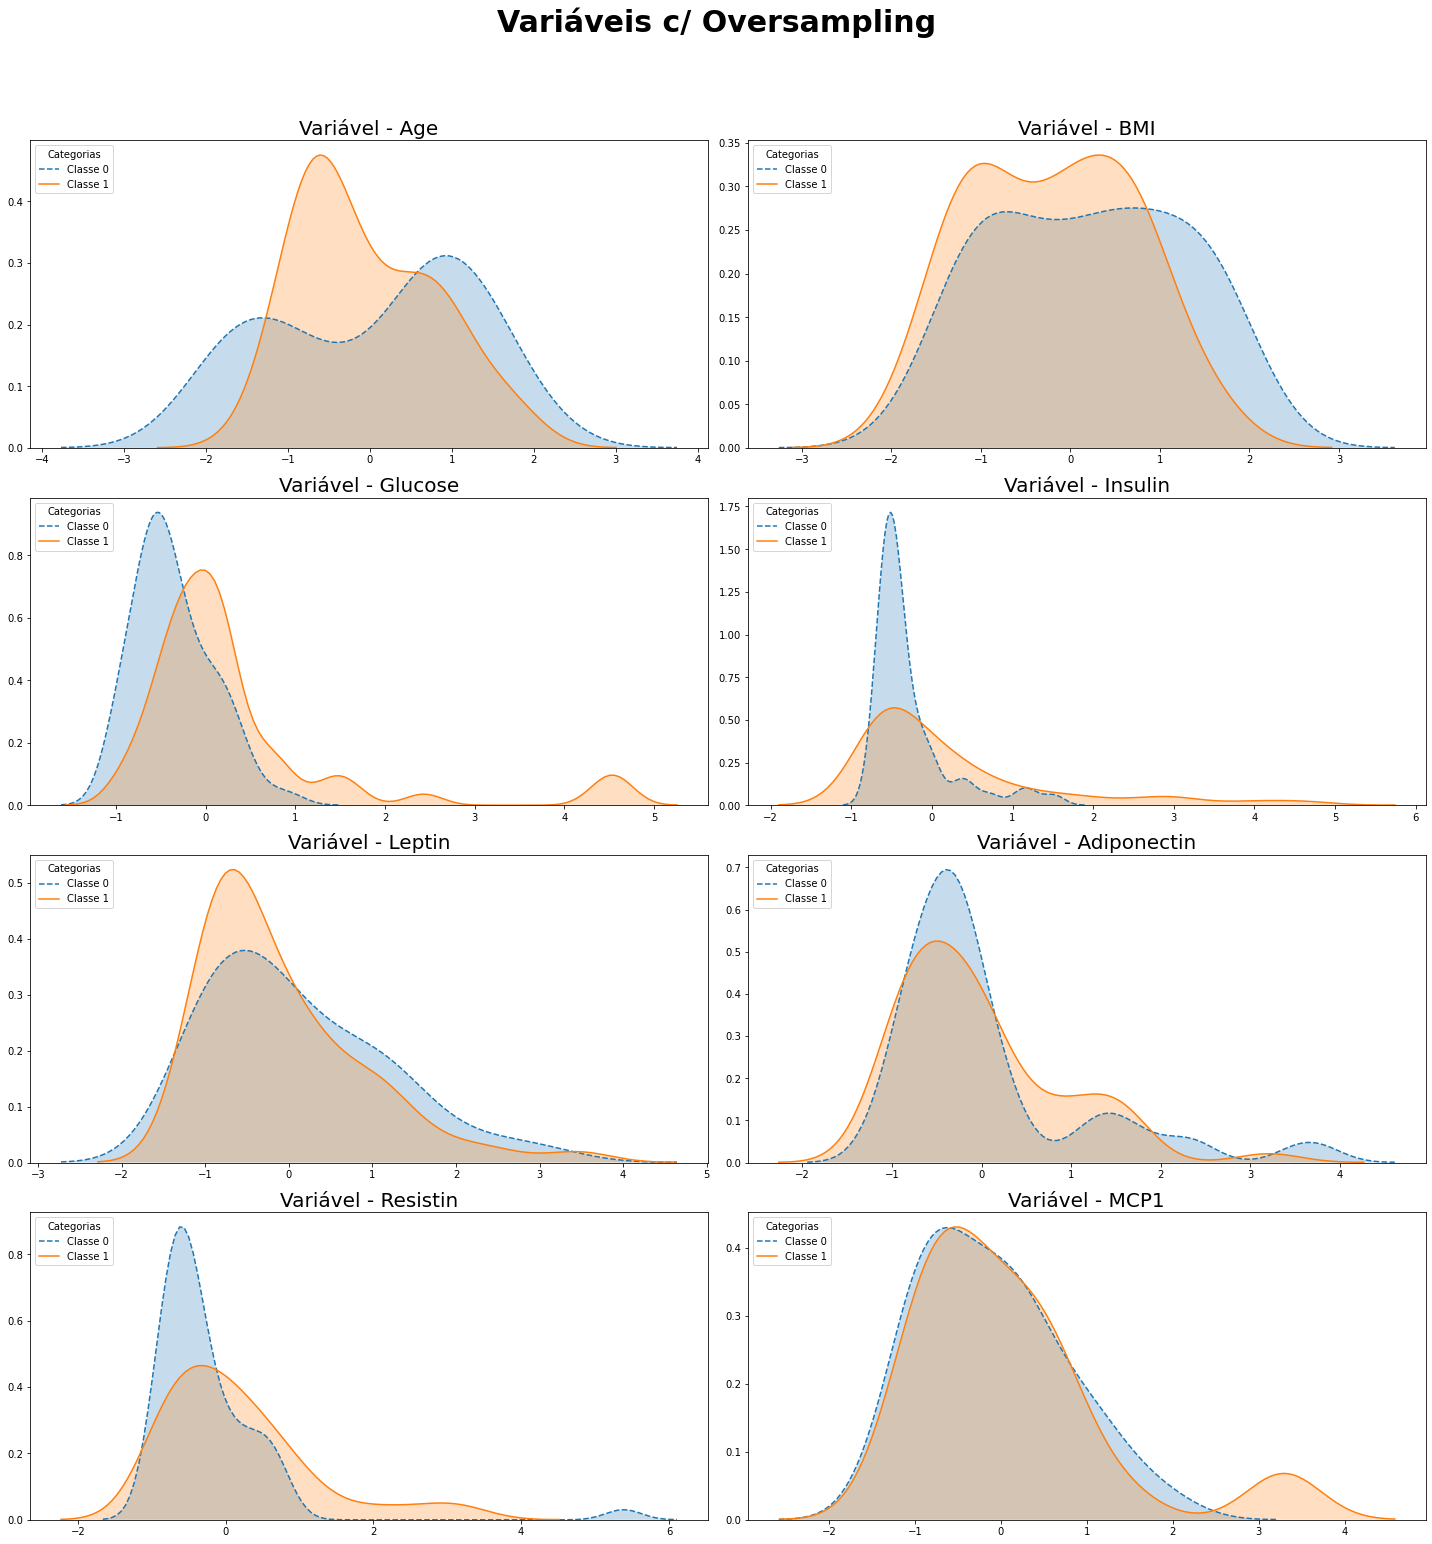

In [26]:
# Definindo a figura
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Variáveis c/ Oversampling', fontsize=30, fontweight='bold', y=1.07)

# Conjunto de entradas in Loop
for f in x_train_smt.columns:
    # Plot distribuição
    sns.kdeplot(x_train_smt.loc[y_train_smt==0, f], shade=True, ax=axes[r][c], label='Classe 0', linestyle="--")
    sns.kdeplot(x_train_smt.loc[y_train_smt==1, f], shade=True, ax=axes[r][c], label='Classe 1')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

**DICA**: Compare este resultado com o anterior para avaliar como estão as distribuições em comparação à original

In [27]:
# Transformar smt na base de dados final
x_train = x_train_smt.copy()
y_train = y_train_smt.copy()

# Deletar variaveis do SMOTE
del x_train_smt, y_train_smt

## Aplicar Transformação
Realizado, pois a adição de novas amostras podem ter movido a média e desvio padrão.

In [28]:
# Definir transformador
transformador = StandardScaler()
# Aplicar no conjunto de treino
x_train = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns)
# Transformar conjunto de teste
x_test = pd.DataFrame(transformador.transform(x_test), columns=x_train.columns)

## Avaliar uma Feature Selection ...

**Note que ao fazer isso, acabei de realizar uma falha: *Data Leakage*. Consegue ver o motivo?**

Como é um notebook mais didático para mostrar técnicas, irei manter esta prática. Além disso quero apresentar este ótimo seletor de variáveis chamado [Boruta](https://github.com/scikit-learn-contrib/boruta_py).

In [29]:
# Definir estimador emsemble que será utilizado
rf = RandomForestClassifier(n_estimators=200, criterion='gini', n_jobs=-1)

# Definir o BORUTA para FS
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1206)

# Buscar variáveis! (só aceita numpy array)
feat_selector.fit(x_train.values, y_train.values.ravel());

In [30]:
# Variáveis selecionadas
for i in x_train.columns[feat_selector.support_]:
    print(i)
print('>',sum(feat_selector.support_),'de',len(x_train.columns),'variáveis permitidas.')

Age
BMI
Glucose
Insulin
Resistin
> 5 de 8 variáveis permitidas.


Segundo o Boruta, apenas 5 variáveis são plausíveis de usar. O interessante é que todas as selecionadas do estudo passaram!

In [31]:
# Definindo conjuntos de features
feats_boruta = ['BMI','Glucose','Age','Resistin','Insulin']
feats_estudo = ['BMI','Glucose','Age','Resistin']

Agora vamos para construção de modelo!


# Construção de modelo: Rede Toda-Conectada (FC)

Trata-se de uma das arquitetura iniciais que surgiram no estudo de *Deep Learning*. Seu modelo consiste em todos os neurônios conectados entre si do início até o final:

![dnn](https://user-images.githubusercontent.com/32513366/71747029-59ab9d00-2e4d-11ea-91d8-2aa03516f9cd.png)

De forma geral seu parâmetro principal (além da profundidade do modelo, isto é, quantidade de camadas) que precisa ser definido é:
- ```units```: quantidades de neurônios presentes naquela camada

## Definindo funções de apoio

### Avaliação de treinamento

In [32]:
def avaliando_resultados_graficos(treinamento):
    # Plots
    fig, ax = plt.subplots(2,1, figsize=(20,20));
    # Metric X Epochs
    ax[0].plot(treinamento.history['binary_accuracy'], label='Desempenho - Treino')
    ax[0].plot(treinamento.history['val_binary_accuracy'], label = 'Desempenho - Validação')
    ax[0].set_title('Treinamento da Rede - Desempenho', fontsize=25, fontweight='bold')
    ax[0].set_xlabel('Epochs', fontsize=20, fontweight='bold')
    ax[0].set_ylabel('Desempenho', fontsize=20, fontweight='bold')
    ax[0].legend(loc='upper left', fontsize=15)
    # Epoch X Epochs
    ax[1].plot(treinamento.history['loss'], label='Custo - Treino')
    ax[1].plot(treinamento.history['val_loss'], label = 'Custo - Validação')
    ax[1].set_title('Treinamento da Rede - Custo', fontsize=25, fontweight='bold')
    ax[1].set_xlabel('Epochs', fontsize=20, fontweight='bold')
    ax[1].set_ylabel('Custo', fontsize=20, fontweight='bold')
    ax[1].legend(loc='upper right', fontsize=15)
    plt.tight_layout()

### Construir FC personalizável

In [33]:
def construirFC(input_dimension, 
                hidden_layers_architecture,
                hidden_layers_activation,
                output_activation,
                use_batchNormalization=False,
                use_dropout=False,
                dropout_rate=0.10):
    
    # Iniciar FC
    DNN = models.Sequential()
    
    # Criar camada de entrada (fixa)
    DNN.add(Input(shape=input_dimension, name='entrada'))
    
    # LOOP - Construir Camadas internas
    for units_in_layer in hidden_layers_architecture:
        DNN.add(layers.Dense(units=units_in_layer))
        if use_batchNormalization:
            DNN.add(layers.BatchNormalization())
        DNN.add(layers.Activation(hidden_layers_activation))
        if use_dropout:
            DNN.add(layers.Dropout(rate=dropout_rate))
    
    # Adicionar camada de saída - COLOCAR para selecionar ativação
    DNN.add(layers.Dense(units=1, activation= output_activation, name='saida'))
    
    # Compilar modelo
    DNN.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])
    
    # Retornar modelo
    return DNN

## Construindo as redes

### Todas as variáveis de entrada selecionadas pelo Boruta

In [34]:
# Gerar modelo
fc_all = construirFC(input_dimension=(len(feats_boruta),),
                     hidden_layers_architecture=[8,16,32],
                     hidden_layers_activation='relu',
                     output_activation='sigmoid',
                     use_batchNormalization=True,
                     use_dropout=False)
# Treinando a rede
fc_all_treino = fc_all.fit(x=x_train[feats_boruta], y=y_train, epochs=50, validation_split=0.15, verbose=0)

### Apenas as variáveis selecionadas no estudo

In [35]:
# Gerar modelo
fc_sel = construirFC(input_dimension=(len(feats_estudo),),
                     hidden_layers_architecture=[8,16,32],
                     hidden_layers_activation='relu',
                     output_activation='sigmoid',
                     use_batchNormalization=True,
                     use_dropout=False)
# Treinando a rede
fc_sel_treino = fc_sel.fit(x=x_train[feats_estudo],y=y_train, epochs=50, validation_split=0.15, verbose=0)

## Analisando os resultados de treinamento
### Todas as variáveis de entrada pelo Boruta

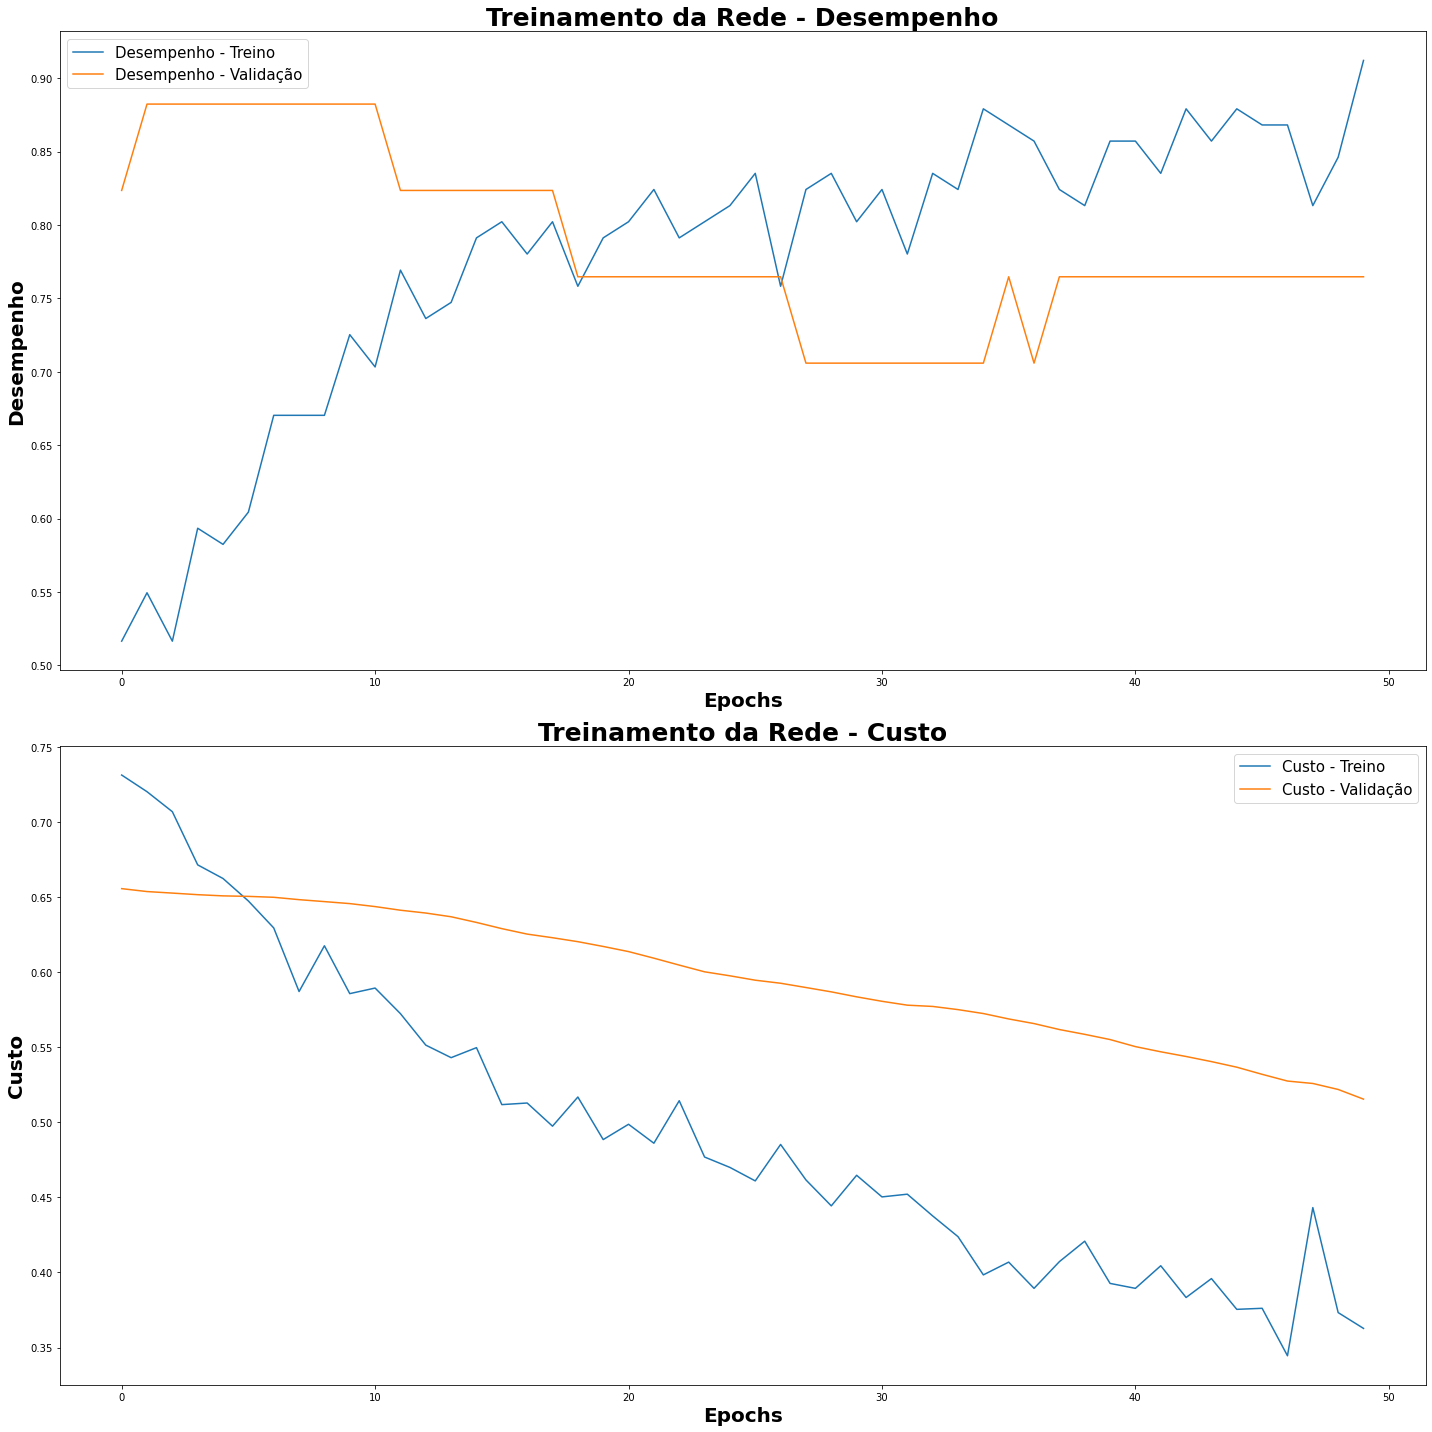

In [36]:
avaliando_resultados_graficos(fc_all_treino)

### Apenas as variáveis selecionadas no estudo

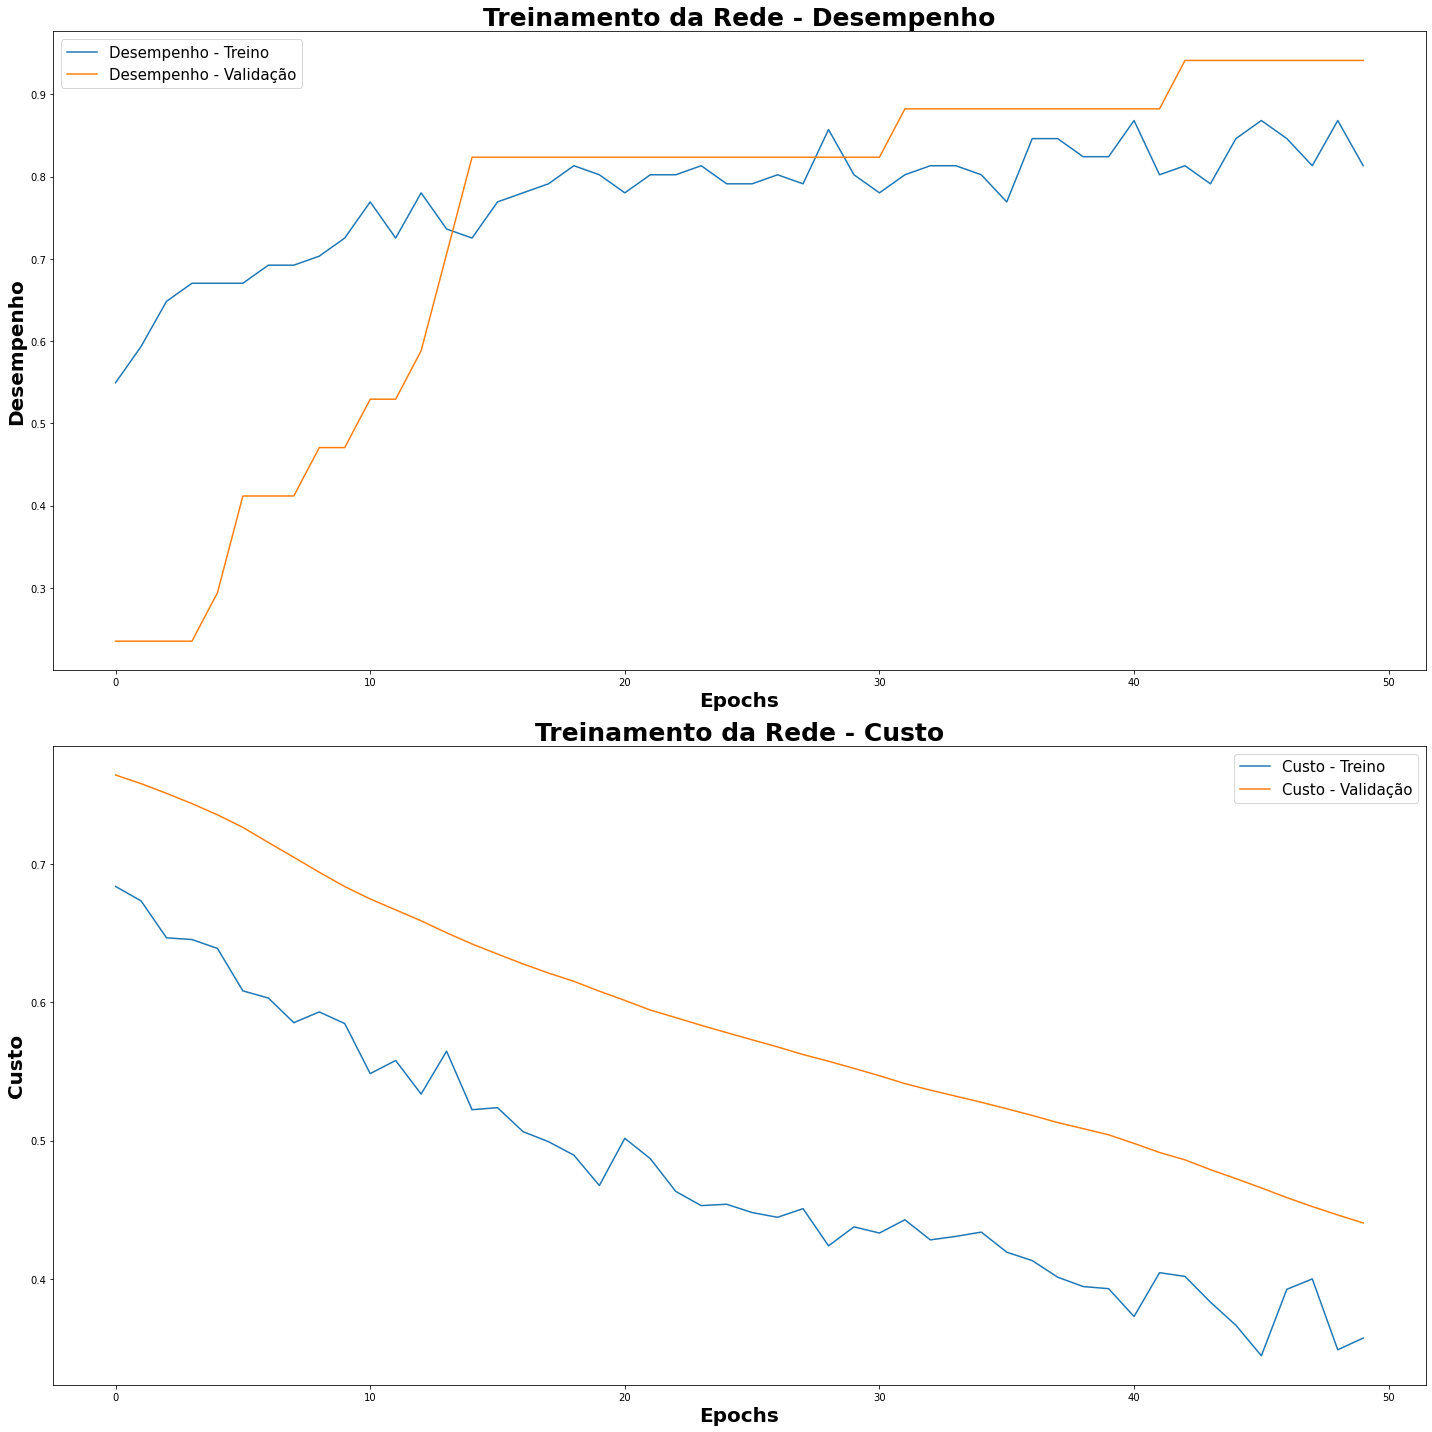

In [37]:
avaliando_resultados_graficos(fc_sel_treino)

Note que ambos os modelos mostraram bons resultados e um gráfico esperado:
- Curva de custo em decadência com a curva de treino sempre abaixo
- Curva de desempenho com uma baixa diferença entre treino e validação

## Desempenho no conjunto de teste
### Todas as variáveis de entrada

In [38]:
# Realizar predição
y_pred_all = (fc_all.predict(x_test[feats_boruta]) > 0.50).astype("int32").reshape(-1,)

In [39]:
# Usando a funcao do sklearn para ter um overview geral do resultado de nosso modelo
print(classification_report(y_test, y_pred_all))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



In [40]:
# Matriz de confusao
pd.DataFrame(confusion_matrix(y_test, y_pred_all, labels=[0, 1]), index=[0, 1], columns=[0, 1])

,0,1
0,7,1
1,1,9


### Apenas as variáveis selecionadas no estudo

In [41]:
# Realizar predição
y_pred_sel = (fc_sel.predict(x_test[feats_estudo]) > 0.50).astype("int32").reshape(-1,)

In [42]:
# Usando a funcao do sklearn para ter um overview geral do resultado de nosso modelo
print(classification_report(y_test, y_pred_sel))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.88      0.70      0.78        10

    accuracy                           0.78        18
   macro avg       0.79      0.79      0.78        18
weighted avg       0.80      0.78      0.78        18



In [43]:
# Matriz de confusao
pd.DataFrame(confusion_matrix(y_test, y_pred_sel, labels=[0, 1]), index=[0, 1], columns=[0, 1])

,0,1
0,7,1
1,3,7


Percebemos que ambos os modelos apresentaram bons resultados! Porém como falamos no início deste notebook, esses modelos de DL são muito famintos por dados. Aqui vai alguns motivos para não confiar nos modelos acima:
- As curvas apesar de mostrarem um bom padrão, possuem uma dinâmica instável (serrilhada)
- Devido a grande quantidade de parâmetros e a baixa quantidade de amostras de teste/treino não sabemos se o modelo aprendeu ou decorou os dados de treino

Visto isso, vamos testar modelos clássicos que são mais simples.

# Construção de modelos clássicos
Como usar DL trouxe resultados duvidáveis, vamos avaliar modelos mais simples para a mesma problemática com apenas as variáveis selecionadas pelo boruta.

## Função de apoio

In [44]:
def printModelGeneralInfo(model, hp, score, metric_evaluated):
    print('#####################################################')
    print('Model:', type(model).__name__)
    print('Metric: ', metric_evaluated, ' | Score (%): ', 100*round(score,5))
    print('Best Parameters: ', hp)
    print('#####################################################\n')

In [45]:
def optimizationGridCV(model_estimator, params, metric_to_eval, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Grid Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = GridSearchCV(estimator=model_estimator,param_grid=params,cv=5,scoring=metric_to_eval,verbose=2,n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [46]:
def optimizationRandomCV(model_estimator, params, metric_to_eval, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Random Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        n_iter: iterations in RandomizedSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = RandomizedSearchCV(estimator=model_estimator,
                                   param_distributions=params, 
                                   n_iter=n_iter,
                                   cv=5,
                                   scoring=metric_to_eval,
                                   verbose=2,
                                   random_state=101,
                                   n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [47]:
def optimizationBayesCV(model_estimator, params, metric_to_eval, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Bayes Optimization Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        n_iter: iterations in BayesSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Search CV object
    hp_search = BayesSearchCV(estimator=model_estimator,
                              search_spaces=params,
                              n_iter=n_iter,
                              cv=5,
                              scoring=metric_to_eval,
                              verbose=0,
                              random_state=101,
                              n_jobs=5,
                              n_points=5)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [48]:
def optimizationPipeline(estimator,params,x_train,y_train,metric_eval,opt_option='grid',n_iter=None):
    """
    Function to apply a specific HP optimization and present results.
    Arguments:
        estimator: Model to be evaluated
        params: hyper parameters grid
        x_train: self explanatory
        y_train: self explanatory
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        opt_option: define the methodology to HP Optimization. Can be 'grid','random' or 'bayes'
        n_iter: iterations in RandomSearchCV or BayesOptimization. It's ignored if opt_option is 'grid'.
    Returns:
        dictionary with overall results
    """  
    # 1 - SEARCH
    if opt_option == 'grid':
        best_model,best_params,best_score,cv_results = optimizationGridCV(estimator,params,metric_eval,x_train,y_train)
    elif opt_option == 'random':
        best_model,best_params,best_score,cv_results = optimizationRandomCV(estimator,params,metric_eval,n_iter,x_train,y_train)
    elif opt_option == 'bayes':
        best_model,best_params,best_score,cv_results = optimizationBayesCV(estimator,params,metric_eval,n_iter,x_train,y_train)
    else:
        print('ERROR - Wrong opt_option selected')
        return
    
    # Wait for results
    sleep(1.5)    
    # 2 - Show Model Results
    printModelGeneralInfo(best_model, best_params, best_score, metric_eval)
    # 3 - Returns
    returned_dict = {'best_model':best_model,'best_params':best_params,'best_score':best_score,
                     'cv_res':pd.DataFrame(cv_results),'metric_used':metric_eval}
    return returned_dict

## Regressão Logística

In [49]:
# Definir estimador
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000)
# Definir parametros
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

# Buscar!
lre = optimizationPipeline(estimator,params,x_train[feats_boruta],y_train,'f1',opt_option='bayes',n_iter=100)

#####################################################
Model: LogisticRegression
Metric:  f1  | Score (%):  76.821
Best Parameters:  OrderedDict([('C', 1.009844344889101), ('class_weight', None), ('l1_ratio', 0.48439095870646465)])
#####################################################



## Random Forest

In [50]:
# Definir Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
# Definir parametros
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
# Buscar!
rfc = optimizationPipeline(estimator,params,x_train[feats_boruta],y_train,'f1',opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  f1  | Score (%):  81.528
Best Parameters:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_leaf', 3), ('min_samples_split', 9), ('n_estimators', 100)])
#####################################################



## SVM

In [51]:
# Definir estimador
estimator = SVC(random_state=1206, probability=True)
# Definir parametros
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}
# Buscar!
svm = optimizationPipeline(estimator,params,x_train[feats_boruta],y_train,'f1',opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  f1  | Score (%):  83.194
Best Parameters:  OrderedDict([('C', 1.324404441199773), ('class_weight', None), ('gamma', 'scale'), ('kernel', 'poly'), ('shrinking', True)])
#####################################################



## Avaliando resultados dos modelos
### Regressão Logística

In [52]:
# Predicao
y_pred = lre['best_model'].predict(x_test[feats_boruta])
# Usando a funcao do sklearn para ter um overview geral do resultado de nosso modelo
print(classification_report(y_test, y_pred))
# Matriz de confusao
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]), index=[0, 1], columns=[0, 1])

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.88      0.70      0.78        10

    accuracy                           0.78        18
   macro avg       0.79      0.79      0.78        18
weighted avg       0.80      0.78      0.78        18



,0,1
0,7,1
1,3,7


### Random Forest

In [53]:
# Predicao
y_pred = rfc['best_model'].predict(x_test[feats_boruta])
# Usando a funcao do sklearn para ter um overview geral do resultado de nosso modelo
print(classification_report(y_test, y_pred))
# Matriz de confusao
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]), index=[0, 1], columns=[0, 1])

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



,0,1
0,7,1
1,1,9


### SVM

In [54]:
# Predicao
y_pred = svm['best_model'].predict(x_test[feats_boruta])
# Usando a funcao do sklearn para ter um overview geral do resultado de nosso modelo
print(classification_report(y_test, y_pred))
# Matriz de confusao
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]), index=[0, 1], columns=[0, 1])

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.82      0.90      0.86        10

    accuracy                           0.83        18
   macro avg       0.84      0.82      0.83        18
weighted avg       0.84      0.83      0.83        18



,0,1
0,6,2
1,1,9


# Conclusão
No geral vemos que utilizar um conjunto amostral muito pequeno traz resultados duvidosos com Deep Learning. Diversos testes foram realizados além dos que se encontram neste `Jupyter` para apresentar estes resultados (incluindo otimização de parâmetros). Ao invés disso, uma simples otimização de parâmetros de modelos clássicos mostraram resultados equivalentes ou superiores.

Ao usar modelos clássicos mais simples encontramos uma melhora nos resultados. Isso deixa evidente o quanto os modelos de DL são "*Data Hungry*". Note que uma Random Forest, modelo mais simples, possui um resultado equivalente à um modelo mais complexo como a DL. Além disso, a regressão Logística mostrou desempenho equivalente a DL mais fraca, ou seja, um dos modelos mais simples de AI conseguiu ficar parelho com uma DL.

Apesar das DL fazerem resultados cada vez mais excepcionais, é importante ter em mente que ela não é a solução de tudo e que pra isso existem outros modelos.

Caso queira saber mais sobre DL recomendo acessar:
- [Deep Learning Brasil](https://www.youtube.com/c/DeepLearningBrasilEmportugu%C3%AAs/videos)
- [Nerdologia](https://www.youtube.com/user/nerdologia) - Para temáticas de tecnologia e IA bem explicadas